In [3]:
!install -U pandas-profiling
!pip install pythainlp
# !pip install --upgrade pythainlp
!pip install pyLDAvis
!pip install sefr_cut

install: invalid option -- 'U'
Try 'install --help' for more information.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nlp lib
from pythainlp.corpus import thai_stopwords

import pythainlp
from pythainlp.tokenize import sent_tokenize, word_tokenize
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import sefr_cut
sefr_cut.load_model(engine='tl-deepcut-ws1000')

import warnings
warnings.filterwarnings('ignore')

loading model.....
Success


In [29]:
df = pd.read_csv('/content/drive/MyDrive/CRM_Analytics/hw11-voice_of_customer/CustomerReviews.csv')
df.head()

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Review ID      21 non-null     int64  
 1   Restaurant_ID  21 non-null     object 
 2   Restaurant     21 non-null     object 
 3   User           21 non-null     object 
 4   Headline       21 non-null     object 
 5   Review         21 non-null     object 
 6   Rating         20 non-null     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ KB


In [5]:
df['Restaurant'].value_counts()

Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ    8
Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G            8
ข้าน้อยขอชาบู                                        5
Name: Restaurant, dtype: int64

In [6]:
# why ployynp has 3 reviews
df['User'].value_counts()

ployynp                             3
saanowy                             1
41841cb99ea243a3a8d4b006e946c586    1
665a902b335b434ab489f00f2fbb477e    1
27a91236fe5e4559a4f097c97a480781    1
40e0e087f3914fd49a8933b5a29936ca    1
fd2ba94ec1bc4948ae109e2cb6c9cbc6    1
f2628bf47a394345b133fec76a79661d    1
0b81d251e4db486f9bcdba73b374ed99    1
12f2b56b28bb4849a92690cedc1cc50a    1
qvanqvan                            1
7eb0c7d8683e407f83cc4d18e51d800d    1
c08b2776067a4026b882abfc6fca8330    1
a477a5812ada4d5b80fd04fca22bdbca    1
a6991f1e0e9b4916ab3ca91d86f8e481    1
backscrash                          1
a96ec47b6cff4bd1834c90d603ef0a7e    1
pakkaramonpondej                    1
7b16469831074f7abc7824745ee75212    1
Name: User, dtype: int64

In [7]:
df[df['User']=='ployynp']

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0
10,11,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,ployynp,บุฟเฟ่ต์คุ้มๆในห้าง,กลับมาอัพเดทราคาชาบูชิ ตอนนี้อยู่ที่ 399 บาท n...,3.0
16,17,436045MJ-ข้าน้อยขอชาบู,ข้าน้อยขอชาบู,ployynp,บุฟเฟ่ต์ชาบูและพิซซ่าไม่อั้นในราคา 199 บาท เน้...,หลังจากที่เคยลองสาขายูเนี่ยนมอลล์ไป รอบนี้มาที...,4.0


In [60]:
# stopwords
stopwords = list(thai_stopwords())
rm_words_lst = ['\u200b']
final_lst = stopwords + rm_words_lst

def rm_stopwords(txt, stopword = final_lst):
  for i in final_lst:
    txt = txt.replace(i, '')
  return txt.strip()

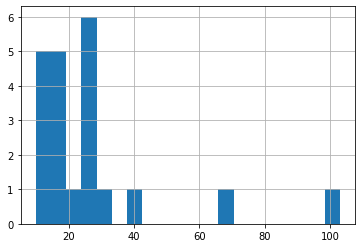

In [62]:
df['review_clean'] = df['Review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['review_clean'] = df['review_clean'].apply(rm_stopwords)
df['sent_tokens'] = df['review_clean'].apply(lambda x:sent_tokenize(x, engine='whitespace+newline') )
df['len_sent_tokens'] = df['sent_tokens'].apply(len)
df['len_sent_tokens'].hist(bins=20)

In [63]:
for i in df['sent_tokens'].sample(3):
  print('-'*10)
  print(i)
  print('-'*10)

----------
['ชาบูชิ', 'สาขาเดอะมอลล์กะปิ', 'ประตู้าห้าง', 'มแมคโดนัล', 'ขนาดร้านดี', 'คิว', 'โชคชะตา', 'ห้างซุ้มร้านโน้นบริเวลาน้าร้านเลือกชอปเบาระหงรอ', 'กลยุทธ์ดี555', 'ร้านเคาน์เตอร์้าสายนแนว', 'หม้อหม้อท่าน', '๊ะหมู่หม้อ', 'อาหารสายนเคลื่อนตัวเลือกย', 'คอเนื้อแน่นจานดำหยิบวางต้มค่า', 'น้ำซุปเลือก3', 'ใส', 'ข้น', 'ต้มยำ', 'อิอิ', 'ภาาหารล่าทาน', 'ปปรุงดี', 'ทานเล่น', 'ชูชิ', 'วปั้น', 'ทอด', 'สลัด', 'หวาน', 'ไอติมเมนูเติม', 'ยอด', 'คุ้มค่าราคา3xx', 'บาท', 'แถมบัตรสชิกเคโออิชิลด', 'ดีค่า']
----------
----------
['านขาบูชิตอนหิว', 'งั้นคุ้มค', 'ฮ่า', 'เมนูกิน', 'อาหารสายน', 'อาหารทานเล่น', 'ซูชิ', 'ปูอัด', 'เกี๊ยวซ่า', 'กุ้งเทมปุระ', 'ลานตา', 'ราคาตอน', '399', 'บาท', 'แพงนึง', 'เยบอาหารคุ้มค']
----------
----------
['ร้านชาบูเฟรนไชส์รสชาติดีคุ้มค่าเหะสมราคา500บาท', 'ติดเรื่องน้ำซุปตอนงวด', 'เค็มปกติกินชาบูค', 'น้ำชาเขียวร้อนกาแฟ', 'ร้าน', 'ชอบเนื้อออสเตรเลียดีค', 'หมูสันคอรสชาติดี', 'แน้ำซุปสุกี้ี้', 'เสิร์ฟน้ำจิ้มไข่ไก่', 'โชยุหวาน', 'นไอศครีมบ๊วยดีค', 'แตำค', 'ลุย']
----------


In [64]:
df['rm_sent_tokens'] = df['sent_tokens'].apply(lambda x: [ i for i in x if len(i)>=6])

In [65]:
df['rm_sent_tokens']

0     [ร้านบริดีพงานรักสะอาดสะอ้านใส่ใจประทับใจบริรส...
1     [นึกชาบูญี่ปุ่น, ราไดซ์, ภาพเค้าตราฐาน, โอกาสท...
2     [นั่ง๊ะ, ระหง๊ะฉากกั้น, น้ำซุปเลือก, น้ำจิ้มแต...
3     [นึกชาบูเนื้อ, ราคาโหด, นึกโมโม่, ร้านโปร, ธรร...
4     [เดิน้าร้านกลิ่นชาบูหอม, โปรบัตรเครดิต, ตัดสิน...
5     [ร้านบุฟเฟ่, ชาบูแนวญี่ปุ่น, สายเนื้อหมู, เนื้...
6     [Number, ราไดส์, สาขาเดอะมอลกะปิ, ร้านอาหารบุฟ...
7     [ร้านชาบูเฟรนไชส์รสชาติดีคุ้มค่าเหะสมราคา500บา...
8     [านขาบูชิตอนหิว, งั้นคุ้มค, เมนูกิน, อาหารสายน...
9     [ชอบกุ้งทอดเทมปุระ, กุ้งเทมปุระคุ้ม, ทานดึกอย,...
10    [อัพเดทราคาชาบูชิ, น้ำซุปเลือก, ซูชิลายตา, เทม...
11    [ห่างหายสำหชาบูชิ, ร้านปราคา, แถมลดเวลา, ภาาหา...
12    [นัดหาวทานเดอะงค์, เอยอาหารบุฟเฟ่ต์ร้าน, ร้านอ...
13    [เลือกกินบุฟเฟต์อาราม์รอคิวท้ายเลิกรอกิน, Shab...
14    [สวัสดีครีวิวร้านชาบูชิ, บุฟเฟขวัญใจ, คนเมนูร้...
15    [ชาบูชิ, สาขาเดอะมอลล์กะปิ, ประตู้าห้าง, มแมคโ...
16    [ลองสาขายูเยนมอลล์, รอบสาขาเดอะมอลล์กะปิชั้น, ...
17    [ร้านบุฟเฟ่ต์โปรโมชั่นหัว199บาท, ทานธรรมดา

# Topic Modeling

In [37]:
df.head()

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating,review_clean,sent_tokens,len_sent_tokens,rm_sent_tokens
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,[ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารัก...,12,[ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารัก...
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,"[นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง, คิดถึงโมโม่, พา...",28,"[นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง, คิดถึงโมโม่, พา..."
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,"[มาทานช่วงนี้, สามารถนั่งโต๊ะเดียวกัน, หม้อเดี...",73,"[มาทานช่วงนี้, สามารถนั่งโต๊ะเดียวกัน, หม้อเดี..."
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,"[ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ, ในราคาไม่โหดจนเ...",17,"[ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ, ในราคาไม่โหดจนเ..."
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,"[เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก, ๆ, ประก...",25,"[เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก, ประกอบก..."


In [66]:
df['tokens'] = df['review_clean'].apply(lambda x: [ w for st in sent_tokenize(x, engine='whitespace+newline') for w in sefr_cut.tokenize(st,k=100)])
df['tokens'] = df['tokens'].apply(lambda x: sum(x,[]))

In [83]:
doc = df['tokens'].to_list()
comb_doc = sum(doc,[])
comb_doc = [i for i in comb_doc if i.isalpha()]
# len(comb_doc)
dictionary = gensim.corpora.Dictionary([comb_doc])
dictionary.token2id.keys()

360

In [89]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in [comb_doc]]
word_freq = [[(dictionary[id], freq) for id, freq in couple] for couple in gensim_corpus]

In [107]:
num_topics = 5
chunksize = 10
passes = 2
iterations = 5
eval_every = 1

temp = dictionary[0]
id2word = dictionary.id2token
model = gensim.models.LdaModel(corpus = gensim_corpus, \
                                     id2word = id2word, \
                                     chunksize=chunksize,\
                                     alpha='auto', eta ='auto',\
                                     iterations = iterations,\
                                     num_topics = num_topics,\
                                     passes=passes,\
                                     eval_every=eval_every)

In [108]:
# pyLDAvis.prepare(model, gensim_corpus, dictionary)
gensimvis.prepare(model, gensim_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.000841  0.001983       1        1  28.623434
3      0.003264  0.000087       2        1  25.843291
0      0.000059 -0.000841       3        1  18.779601
2     -0.002380 -0.000574       4        1  14.108802
4     -0.000102 -0.000655       5        1  12.644873, topic_info=      Term       Freq      Total Category  logprob  loglift
49     ทาน  15.000000  15.000000  Default  30.0000  30.0000
111  อาหาร  11.000000  11.000000  Default  29.0000  29.0000
78    ราคา  11.000000  11.000000  Default  28.0000  28.0000
122   เวลา   5.000000   5.000000  Default  27.0000  27.0000
91    สาขา   8.000000   8.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
74      รอ   0.343146   2.897823   Topic5  -4.8878  -0.0656
31      ชม   0.335608   2.881614   Topic5  -4.9100  -0.0822
86      สม   0.335863   2.916934   Topic5  -4.9092  -0.0937
149   โอเค   0.333300   2.895451   Topic5  -4.9169  -0.0939
64     ภาพ   0.359273   3.605677   Topic5  -4.8419  -0.2383

[301 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.450672  CTW
0         2  0.450672  CTW
1         1  0.345447    G
1         2  0.345447    G
1         3  0.345447    G
...     ...       ...  ...
150       5  0.208069   ใจ
151       1  0.452393   ใส
151       2  0.452393   ใส
156       1  0.453762   ไอ
156       2  0.453762   ไอ

[159 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 5])